In [5]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('CompleteDataSet.csv')

# rename column headers to make it easier to remove columns, original columns are quite confusing: TimeStamps,AnkleAccelerometer x-axis (g),
# AnkleAccelerometer y-axis (g),AnkleAccelerometer z-axis (g),AnkleAngularVelocity x-axis (deg/s),
# AnkleAngularVelocity y-axis (deg/s),AnkleAngularVelocity z-axis (deg/s),AnkleLuminosity illuminance (lx),RightPocketAccelerometer x-axis (g),
# RightPocketAccelerometer y-axis (g),RightPocketAccelerometer z-axis (g),
# RightPocketAngularVelocity x-axis (deg/s),RightPocketAngularVelocity y-axis (deg/s),RightPocketAngularVelocity z-axis (deg/s),
# RightPocketLuminosity illuminance (lx),BeltAccelerometer x-axis (g),BeltAccelerometer y-axis (g),
# BeltAccelerometer z-axis (g),BeltAngularVelocity x-axis (deg/s),BeltAngularVelocity y-axis (deg/s),BeltAngularVelocity z-axis (deg/s),
# BeltLuminosity illuminance (lx),NeckAccelerometer x-axis (g),NeckAccelerometer y-axis (g),
# NeckAccelerometer z-axis (g),NeckAngularVelocity x-axis (deg/s),NeckAngularVelocity y-axis (deg/s),NeckAngularVelocity z-axis (deg/s),
# NeckLuminosity illuminance (lx),WristAccelerometer x-axis (g),WristAccelerometer y-axis (g),
# WristAccelerometer z-axis (g),WristAngularVelocity x-axis (deg/s),WristAngularVelocity y-axis (deg/s),WristAngularVelocity z-axis (deg/s),
# WristLuminosity illuminance (lx),BrainSensor,Infrared1,Infrared2,Infrared3,Infrared4,
# Infrared5,Infrared6,Subject,Activity,Trial,Tag

# List of columns we want to keep, we get rid of everything we don't need
columns_to_keep = [
    'TimeStamps',
    'WristAccelerometer x-axis (g)',
    'WristAccelerometer y-axis (g)',
    'WristAccelerometer z-axis (g)',
    'WristAngularVelocity x-axis (deg/s)',
    'WristAngularVelocity y-axis (deg/s)',
    'WristAngularVelocity z-axis (deg/s)',
    'WristLuminosity illuminance (lx)',
    'Subject',
    'Activity',
    'Trial'
]

# Keep only the columns listed above
df_cleaned = df[columns_to_keep]

#  Code to calculate magnitude of acceleration and add it as a new column in dataframe
df['Acceleration Magnitude (g)'] = np.sqrt(
    df['WristAccelerometer x-axis (g)']**2 +
    df['WristAccelerometer y-axis (g)']**2 +
    df['WristAccelerometer z-axis (g)']**2
)

# Code to calculate magnitude of velocity
df['Angular Velocity Magnitude (deg/s)'] = np.sqrt(
    df['WristAngularVelocity x-axis (deg/s)']**2 +
    df['WristAngularVelocity y-axis (deg/s)']**2 +
    df['WristAngularVelocity z-axis (deg/s)']**2
)

df['SMA_Acceleration'] = (df['WristAccelerometer x-axis (g)'].abs() +
                          df['WristAccelerometer y-axis (g)'].abs() +
                          df['WristAccelerometer z-axis (g)'].abs())

# Calculate SMA for angular velocity
df['SMA_AngularVelocity'] = (df['WristAngularVelocity x-axis (deg/s)'].abs() +
                             df['WristAngularVelocity y-axis (deg/s)'].abs() +
                             df['WristAngularVelocity z-axis (deg/s)'].abs())

# Calculate Energy for acceleration
df['Energy_Acceleration'] = (df['WristAccelerometer x-axis (g)']**2 +
                             df['WristAccelerometer y-axis (g)']**2 +
                             df['WristAccelerometer z-axis (g)']**2)

# Calculate Energy for angular velocity
df['Energy_AngularVelocity'] = (df['WristAngularVelocity x-axis (deg/s)']**2 +
                                df['WristAngularVelocity y-axis (deg/s)']**2 +
                                df['WristAngularVelocity z-axis (deg/s)']**2)

# Calculating the angle with respect to each axis
df['Angle_with_X_deg'] = np.degrees(np.arccos(df['WristAccelerometer x-axis (g)'] / df['Acceleration Magnitude (g)']))
df['Angle_with_Y_deg'] = np.degrees(np.arccos(df['WristAccelerometer y-axis (g)'] / df['Acceleration Magnitude (g)']))
df['Angle_with_Z_deg'] = np.degrees(np.arccos(df['WristAccelerometer z-axis (g)'] / df['Acceleration Magnitude (g)']))

# Save the cleaned data to a new CSV file
df.to_csv('Cleaned_Dataset.csv', index=False)

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr

# Read the cleaned data
df = pd.read_csv('Cleaned_Dataset.csv')

# Ensure Columns are correctly spelled and exist in your DataFrame
print(df.columns)

# Group Data by Subject Activity and Trial
grouped = df.groupby(['Subject', 'Activity', 'Trial'])

# Define functions
def sma(series):
    return np.mean(np.abs(series))

def energy(series):
    return np.sum(np.square(series)) / len(series)

def entropy(series):
    probability = np.unique(series, return_counts=True)[1] / len(series)
    return -np.sum(probability * np.log2(probability))

def range_func(series):
    return series.max() - series.min()

def calc_iqr(series):
    return iqr(series)

def calc_corr(series1, series2):
    return np.corrcoef(series1, series2)[0, 1]

df['TimeStamps'] = pd.to_datetime(df['TimeStamps'])

# Calculate the time difference in seconds between successive measurements
df['TimeDiff'] = df.groupby(['Subject', 'Activity', 'Trial'])['TimeStamps'].diff().dt.total_seconds().fillna(0)

# Correct the grouping for speed and acceleration change calculations to include 'Activity'
df['Speed_X'] = df.groupby(['Subject', 'Activity', 'Trial'])['WristAccelerometer x-axis (g)'].diff().div(df['TimeDiff'])
df['Speed_Y'] = df.groupby(['Subject', 'Activity', 'Trial'])['WristAccelerometer y-axis (g)'].diff().div(df['TimeDiff'])
df['Speed_Z'] = df.groupby(['Subject', 'Activity', 'Trial'])['WristAccelerometer z-axis (g)'].diff().div(df['TimeDiff'])

df['AccChange_X'] = df.groupby(['Subject', 'Activity', 'Trial'])['Speed_X'].diff().div(df['TimeDiff'])
df['AccChange_Y'] = df.groupby(['Subject', 'Activity', 'Trial'])['Speed_Y'].diff().div(df['TimeDiff'])
df['AccChange_Z'] = df.groupby(['Subject', 'Activity', 'Trial'])['Speed_Z'].diff().div(df['TimeDiff'])

# Apply aggregations
summary_df = grouped.agg({
    'WristAccelerometer x-axis (g)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'WristAccelerometer y-axis (g)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'WristAccelerometer z-axis (g)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'WristAngularVelocity x-axis (deg/s)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'WristAngularVelocity y-axis (deg/s)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'WristAngularVelocity z-axis (deg/s)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'Acceleration Magnitude (g)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'Angular Velocity Magnitude (deg/s)': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis, sma, energy, entropy, range_func, calc_iqr],
    'SMA_Acceleration': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis],
    'SMA_AngularVelocity': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis],
    'Energy_Acceleration': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis],
    'Energy_AngularVelocity': ['mean', 'std', 'min', 'max', 'median', 'var', skew, kurtosis],
    'Angle_with_X_deg': ['mean', 'min', 'max'],
    'Angle_with_Y_deg': ['mean', 'min', 'max'],
    'Angle_with_Z_deg': ['mean', 'min', 'max'],
    'Speed_X': ['mean', 'std', 'min', 'max'],
    'AccChange_X': ['mean', 'std', 'min', 'max'],
    'Speed_Y': ['mean', 'std', 'min', 'max'],
    'AccChange_Y': ['mean', 'std', 'min', 'max'],
    'Speed_Z': ['mean', 'std', 'min', 'max'],
    'AccChange_Z': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flatten MultiIndex columns
summary_df.columns = [' '.join(col).strip() for col in summary_df.columns.values]

# Calculate correlations
def calculate_extra_features(group):
    features = {}
    features.update({
        'Acc_XY_corr': calc_corr(group['WristAccelerometer x-axis (g)'], group['WristAccelerometer y-axis (g)']),
        'Acc_XZ_corr': calc_corr(group['WristAccelerometer x-axis (g)'], group['WristAccelerometer z-axis (g)']),
        'Acc_YZ_corr': calc_corr(group['WristAccelerometer y-axis (g)'], group['WristAccelerometer z-axis (g)'])
    })

    return pd.Series(features)

extra_features_df = grouped.apply(calculate_extra_features).reset_index()

# Merge the summary statistics and additional features
final_df = pd.merge(summary_df, extra_features_df, on=['Subject', 'Activity', 'Trial'], how='inner')

# Save to CSV
final_df.to_csv('Engineered.csv', index=False)

Index(['TimeStamps', 'AnkleAccelerometer x-axis (g)',
       'AnkleAccelerometer y-axis (g)', 'AnkleAccelerometer z-axis (g)',
       'AnkleAngularVelocity x-axis (deg/s)',
       'AnkleAngularVelocity y-axis (deg/s)',
       'AnkleAngularVelocity z-axis (deg/s)',
       'AnkleLuminosity illuminance (lx)',
       'RightPocketAccelerometer x-axis (g)',
       'RightPocketAccelerometer y-axis (g)',
       'RightPocketAccelerometer z-axis (g)',
       'RightPocketAngularVelocity x-axis (deg/s)',
       'RightPocketAngularVelocity y-axis (deg/s)',
       'RightPocketAngularVelocity z-axis (deg/s)',
       'RightPocketLuminosity illuminance (lx)',
       'BeltAccelerometer x-axis (g)', 'BeltAccelerometer y-axis (g)',
       'BeltAccelerometer z-axis (g)', 'BeltAngularVelocity x-axis (deg/s)',
       'BeltAngularVelocity y-axis (deg/s)',
       'BeltAngularVelocity z-axis (deg/s)', 'BeltLuminosity illuminance (lx)',
       'NeckAccelerometer x-axis (g)', 'NeckAccelerometer y-axis (g)',
     

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Engineered.csv')

# Function to categorize 'Activity' into 'fall' or 'non-fall'
def categorize_activity(row):
    if 1 <= row['Activity'] <= 5:
        return 'fall'
    else:
        return 'non-fall'

# Apply the categorization
df['Activity'] = df.apply(categorize_activity, axis=1)

# Splitting the dataset based on 'Subject'
train_df = df[df['Subject'].isin(range(1, 12))].copy()  # Include subjects 1 through 11
test_df = df[df['Subject'].isin(range(12, 18))].copy()  # Include subjects 12 through 17

# Dropping 'Trial' column as it is not needed for training/testing
# 'Subject' column will be retained as per your requirement
train_df.drop(['Trial'], axis=1, inplace=True)
test_df.drop(['Trial'], axis=1, inplace=True)

# Reordering columns to place 'Subject' and 'Activity' at the end for consistency
columns_order = [col for col in train_df.columns if col not in ['Subject', 'Activity']] + ['Subject', 'Activity']
train_df = train_df[columns_order]
test_df = test_df[columns_order]

# Saving the prepared datasets
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Train and test datasets prepared and saved.")

Train and test datasets prepared and saved.


In [8]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import os
import warnings
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Dense
from kerastuner.tuners import RandomSearch
warnings.filterwarnings('ignore')

In [12]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

Shape of train data is: (361, 174)
Shape of test data is: (198, 174)


In [13]:
pd.set_option("display.max_columns", None)

In [14]:
train_data.head()

WristAccelerometer x-axis (g) mean  WristAccelerometer x-axis (g) std  \
0                           -0.856487                           0.476209   
1                           -0.661751                           0.469464   
2                           -0.507593                           0.457528   
3                           -0.229783                           0.519600   
4                           -0.252144                           0.566820   

   WristAccelerometer x-axis (g) min  WristAccelerometer x-axis (g) max  \
0                             -3.841                              0.631   
1                             -3.764                              0.110   
2                             -3.070                              0.078   
3                             -1.813                              0.562   
4                             -2.664                              0.374   

   WristAccelerometer x-axis (g) median  WristAccelerometer x-axis (g) var  \
0                                -0.802                           0.226775   
1                                -0.799                           0.220397   
2                                -0.226                           0.209332   
3                                 0.042                           0.269984   
4                                 0.019                           0.321285   

   WristAccelerometer x-axis (g) skew  WristAccelerometer x-axis (g) kurtosis  \
0                           -3.448494                               18.895059   
1                           -1.862240                                9.845226   
2                           -1.967674                                5.675237   
3                           -1.289113                                0.428075   
4                           -2.227209                                4.533172   

   WristAccelerometer x-axis (g) sma  WristAccelerometer x-axis (g) energy  \
0                           0.862959                              0.959182   
1                           0.666508                              0.657169   
2                           0.509201                              0.465904   
3                           0.341032                              0.321065   
4                           0.291662                              0.383214   

   WristAccelerometer x-axis (g) entropy  \
0                               6.600644   
1                               6.340225   
2                               5.663753   
3                               5.858343   
4                               5.534661   

   WristAccelerometer x-axis (g) range_func  \
0                                     4.472   
1                                     3.874   
2                                     3.148   
3                                     2.375   
4                                     3.038   

   WristAccelerometer x-axis (g) calc_iqr  WristAccelerometer y-axis (g) mean  \
0                                 0.29200                           -0.357195   
1                                 0.64800                           -0.252746   
2                                 0.66925                           -0.281454   
3                                 0.82800                           -0.821306   
4                                 0.21900                           -0.163246   

   WristAccelerometer y-axis (g) std  WristAccelerometer y-axis (g) min  \
0                           0.208492                             -1.109   
1                           0.217591                             -1.006   
2                           0.162695                             -0.635   
3                           0.419653                             -2.606   
4                           0.292673                             -1.104   

   WristAccelerometer y-axis (g) max  WristAccelerometer y-axis (g) median  \
0                              0.197                               -0.2910   
1                           

In [15]:
train_data.columns

Index(['WristAccelerometer x-axis (g) mean',
       'WristAccelerometer x-axis (g) std',
       'WristAccelerometer x-axis (g) min',
       'WristAccelerometer x-axis (g) max',
       'WristAccelerometer x-axis (g) median',
       'WristAccelerometer x-axis (g) var',
       'WristAccelerometer x-axis (g) skew',
       'WristAccelerometer x-axis (g) kurtosis',
       'WristAccelerometer x-axis (g) sma',
       'WristAccelerometer x-axis (g) energy',
       ...
       'Speed_Z max', 'AccChange_Z mean', 'AccChange_Z std', 'AccChange_Z min',
       'AccChange_Z max', 'Acc_XY_corr', 'Acc_XZ_corr', 'Acc_YZ_corr',
       'Subject', 'Activity'],
      dtype='object', length=174)

In [16]:
train_data.describe()

WristAccelerometer x-axis (g) mean  WristAccelerometer x-axis (g) std  \
count                          361.000000                         361.000000   
mean                             0.023647                           0.381832   
std                              0.616320                           0.300336   
min                             -1.062961                           0.001084   
25%                             -0.398688                           0.150595   
50%                              0.029158                           0.376547   
75%                              0.575480                           0.530529   
max                              1.027114                           1.453394   

       WristAccelerometer x-axis (g) min  WristAccelerometer x-axis (g) max  \
count                         361.000000                         361.000000   
mean                           -1.144479                           1.269241   
std                             1.153284                           1.312661   
min                            -5.502000                          -0.920000   
25%                            -1.721000                           0.352000   
50%                            -1.015000                           1.101000   
75%                            -0.366000                           1.912000   
max                             0.924000                           7.115000   

       WristAccelerometer x-axis (g) median  \
count                            361.000000   
mean                               0.020265   
std                                0.609239   
min                               -1.030000   
25%                               -0.430000   
50%                               -0.014000   
75%                                0.596000   
max                                0.963000   

       WristAccelerometer x-axis (g) var  WristAccelerometer x-axis (g) skew  \
count                         361.000000                          361.000000   
mean                            0.235748                            0.169981   
std                             0.356964                            2.216528   
min                             0.000001                           -7.225073   
25%                             0.022679                           -0.968139   
50%                             0.141787                            0.160478   
75%                             0.281462                            1.239639   
max                             2.112354                            7.130129   

       WristAccelerometer x-axis (g) kurtosis  \
count                              361.000000   
mean                                 9.234706   
std                                 15.737773   
min                                 -1.816752   
25%                                  0.201572   
50%                                  3.075820   
75%                                 10.637141   
max                                141.433605   

       WristAccelerometer x-axis (g) sma  \
count                         361.000000   
mean                            0.617583   
std                             0.299562   
min                             0.017373   
25%                             0.345711   
50%                             0.605132   
75%                             0.910514   
max                             1.353494   

       WristAccelerometer x-axis (g) energy  \
count                            361.000000   
mean                               0.614259   
std                                0.546515   
min                                0.000349   
25%                                0.261402   
50%                                0.468894   
75%                                0.854706   
max                                3.057152   

       WristAccelerometer x-axis (g) entropy  \
count                             361.000000   
mean                                6.311574   
std                   

In [17]:
train_data['Activity'].unique()

array(['fall', 'non-fall'], dtype=object)

<Axes: xlabel='Activity'>

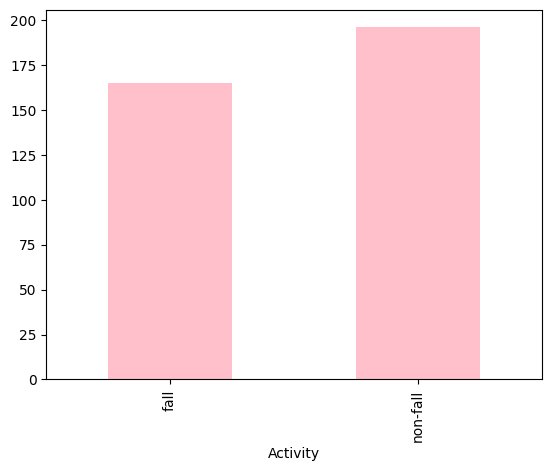

In [18]:
train_data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

In [19]:
x_train, y_train = train_data.iloc[:, :-2], train_data.iloc[:, -1:]
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_train.shape, y_train.shape

((361, 172), (361, 1))

In [20]:
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_test.shape, y_test.shape

((198, 172), (198, 1))

In [21]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [22]:
x_test.shape, y_test.shape, x_train.shape, y_train.shape

((198, 172), (198,), (361, 172), (361,))

In [23]:
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_test = scaling_data.transform(x_test)

In [24]:
model = Sequential()
model.add(Dense(units=64,kernel_initializer='normal',activation='sigmoid',input_dim=x_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=6,kernel_initializer='normal',activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size = 64, epochs= 10,validation_data = (x_test,y_test))

Epoch 1/10
6/6 [==============================] - 1s 53ms/step - loss: 1.5906 - accuracy: 0.4017 - val_loss: 1.3955 - val_accuracy: 0.4545
Epoch 2/10
6/6 [==============================] - 0s 11ms/step - loss: 1.2942 - accuracy: 0.4903 - val_loss: 1.1410 - val_accuracy: 0.4545
Epoch 3/10
6/6 [==============================] - 0s 11ms/step - loss: 1.0766 - accuracy: 0.5623 - val_loss: 0.9653 - val_accuracy: 0.4545
Epoch 4/10
6/6 [==============================] - 0s 13ms/step - loss: 0.9198 - accuracy: 0.6066 - val_loss: 0.8518 - val_accuracy: 0.6515
Epoch 5/10
6/6 [==============================] - 0s 10ms/step - loss: 0.8379 - accuracy: 0.5928 - val_loss: 0.7811 - val_accuracy: 0.9343
Epoch 6/10
6/6 [==============================] - 0s 10ms/step - loss: 0.7706 - accuracy: 0.6039 - val_loss: 0.7374 - val_accuracy: 0.6414
Epoch 7/10
6/6 [==============================] - 0s 15ms/step - loss: 0.7280 - accuracy: 0.6704 - val_loss: 0.7089 - val_accuracy: 0.6010
Epoch 8/10
6/6 [===========

In [25]:
import tensorflow as tf
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [26]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 25)):
        model.add(layers.Dense(units = hp.Int('units' + str(i), min_value=32, max_value=512, step=32),
                               kernel_initializer= hp.Choice('initializer', ['uniform', 'normal']),
                               activation= hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])))
    model.add(layers.Dense(6, kernel_initializer= hp.Choice('initializer', ['uniform', 'normal']), activation='softmax'))
    model.add(
            Dropout(0.2))
    model.compile(
        optimizer = 'adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials= 5,
    executions_per_trial=3,
    directory='project', project_name = 'Human_activity_recognition')

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 25, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
initializer (Choice)
{'default': 'uniform', 'conditions': [], 'values': ['uniform', 'normal'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [ ]:
tuner.search(x_train, y_train,
             epochs= 10,
             validation_data=(x_test, y_test))

Trial 3 Complete [00h 00m 28s]
val_accuracy: 0.5454545617103577

Best val_accuracy So Far: 0.5454545617103577
Total elapsed time: 00h 01m 18s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
21                |14                |num_layers
288               |448               |units0
normal            |normal            |initializer
tanh              |relu              |activation
96                |160               |units1
384               |32                |units2
32                |32                |units3
416               |32                |units4
320               |32                |units5
160               |32                |units6
480               |32                |units7
480               |32                |units8
288               |32                |units9
96                |32                |units10
224               |32                |units11
128               |32                |units12
512               |32                |unit

In [ ]:
tuner.results_summary()

In [ ]:
model=tuner.get_best_models(num_models=1)[0]
history = model.fit(x_train,y_train, epochs=51, validation_data=(x_test,y_test))

In [ ]:
model.summary()
import tensorflow as tf

from tensorflow import keras

Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fitt = model.fit(x_train,y_train, epochs=200, validation_data=(x_test,y_test), callbacks=Callback)

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'mo_fitt' is your training history object
accuracy = mo_fitt.history['accuracy']
loss = mo_fitt.history['loss']
validation_loss = mo_fitt.history['val_loss']
validation_accuracy = mo_fitt.history['val_accuracy']

# Calculate the number of epochs
epochs = len(accuracy)  # Assuming accuracy and loss arrays have the same length

# Plotting
plt.figure(figsize=(15, 7))

# Plot for Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy: Training vs Validation')

# Plot for Loss
plt.subplot(2, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss: Training vs Validation')

# Show plot
plt.show()

# Print the final accuracy as a single figure
print(f'Final Training Accuracy: {accuracy[-1]:.4f}')
print(f'Final Validation Accuracy: {validation_accuracy[-1]:.4f}')